In [1]:
from pathlib import Path
import re

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme()

In [2]:
osu_results_folder = Path("./lumi_osu_results/")
tests = {
    "allgather": {"processes": 3, "metric": "Latency (us)"},
    "bw": {"processes": 2, "metric": "Bandwidth (MB/s)"},
    "latency": {"processes": 2, "metric": "Latency (us)"},
}
test_methods = [
    "cotainr-hybrid-mpich3",
    "cotainr-hybrid-mpich4",
    "cotainr-bind-mpich3",
    "cotainr-bind-mpich4",
    "cray-python",
    "lumi-sif",
]

In [3]:
def extract_nodes(*, file_name):
    if "-single" in file_name:
        nodes = "single"
    elif "-multi" in file_name:
        nodes = "multi"
    else:
        raise ValueError(f"file_name= does not contain 'single' or 'multi'")

    return nodes


def extract_test_method(*, file_name):
    file_name_parts = file_name.split("-")
    test_method = "-".join(
        # fmt: off
        file_name_parts[1:3] # name of module/container, e.g. cotainr-bind or cray-python
        + (
            [file_name_parts[7]]  # mpich3/mpich4 for cotainr containers
            if "cotainr" in file_name else []
          )
        # fmt: on
    )

    return test_method


def read_osu_results_file(*, file_path):
    with file_path.open(mode="r") as f:
        test_name = f.readline().removeprefix("# ").strip()
        column_names = re.split(r"\s{2,}", f.readline().removeprefix("# ").strip())
    osu_colspecs = [(0, 16), (16, 29)]
    osu_dtypes = {column_names[0]: "int64", column_names[1]: "float64"}
    df_osu_results = pd.read_fwf(
        file_path,
        colspecs=osu_colspecs,
        header=1,
        names=column_names,
        dtype=osu_dtypes,
    )
    df_osu_results["Nodes"] = extract_nodes(file_name=file_path.name)
    df_osu_results["Test method"] = extract_test_method(file_name=file_path.name)
    df_osu_results.attrs["name"] = test_name

    return df_osu_results


def show_osu_pivot_table(*, df, metric, test_methods):
    df_pivot = (
        df.pivot(index="Size (B)", columns=["Test method", "Nodes"], values=[metric])
        .reindex(columns=test_methods, level="Test method")
        .reindex(columns=["single", "multi"], level="Nodes")
        # .sort_index(axis="columns", level="Nodes", ascending=False)
        # .sort_index(axis="columns", level="Test method", sort_remaining=False)
    )
    return df_pivot


def barplot_osu_results(*, df, metric, processes, test_methods):
    fig, axes = plt.subplots(2, 1, figsize=(15, 15))
    for ax, nodes in zip(axes, ["single", "multi"]):
        sns.barplot(
            df.loc[df["Nodes"] == nodes],
            x="Size (B)",
            y=metric,
            hue="Test method",
            hue_order=test_methods,
            ax=ax,
        )
        ax.tick_params(axis="x", labelrotation=45)
        ax.set_yscale("log")
        ax.legend(title="Multiple nodes" if nodes == "multi" else "Single node")

    fig.suptitle(f"LUMI-C OSU {df.attrs['name']} results - {processes} processes")
    fig.tight_layout()

    return fig

In [4]:
osu_result_dfs = {
    test_name: pd.concat(
        [
            read_osu_results_file(file_path=file_path)
            for file_path in osu_results_folder.glob(f"*-{test_name}-*")
        ]
    )
    for test_name in tests
}

## Allgather test results

In [5]:
show_osu_pivot_table(
    df=osu_result_dfs["allgather"],
    metric=tests["allgather"]["metric"],
    test_methods=test_methods,
)

Latency (us)                                           \
Test method cotainr-hybrid-mpich3           cotainr-hybrid-mpich4            
Nodes                      single     multi                single    multi   
Size (B)                                                                     
1                            0.81     92.21                  1.16    36.28   
2                            0.80     92.42                  1.16    36.26   
4                            0.80     94.12                  1.16    36.26   
8                            0.79     95.48                  1.16    36.26   
16                           0.77     97.79                  1.16    36.21   
32                           0.80     98.01                  1.15    36.38   
64                           0.78     98.01                  1.15    36.59   
128                          0.81     98.05                  1.15    36.74   
256                          0.85     98.05                  1.18    71.80   
512                          0.89    110.04                  1.21    70.07   
1024                         0.91    196.04                  1.29    94.22   
2048                         1.11    258.70                  1.42    79.90   
4096                         1.36    565.23                  1.59    82.43   
8192                         1.86    466.76                  1.87    86.34   
16384                        2.71    713.04                  3.71   102.64   
32768                        4.38    871.39                  5.17   114.50   
65536                        8.18   1443.35                  8.41   181.12   
131072                      15.40   3150.27                 17.41   257.78   
262144                      28.36   5622.42                 31.34   386.26   
524288                      62.53  11141.02                 60.25   610.52   
1048576                    136.67  22082.87                122.10  1173.85   

                                                                     \
Test method cotainr-bind-mpich3         cotainr-bind-mpich4           
Nodes                    single   multi              single   multi   
Size (B)                                                              
1                          1.36    6.81                1.31    6.81   
2                          1.32    6.79                1.34    6.79   
4                          1.32    6.82                1.33    6.82   
8                          1.30    6.78                1.31    6.79   
16                         1.30    6.80                1.32    6.80   
32                         1.30    6.79                1.33    6.82   
64                         1.32    6.80                1.33    6.77   
128                        1.32    7.43                1.33    7.40   
256                        1.34    9.11                1.34    8.83   
512                        1.38    9.37                1.37    9.65   
1024                       1.41    9.88                1.40    9.93   
2048                       1.48   10.16                1.50   10.26   
4096                       1.63   10.49                1.63   10.58   
8192                       4.29   12.36                4.30   12.19   
16384                      5.16   14.35                5.18   14.02   
32768                      7.07   23.34                6.91   23.52   
65536                     11.18   31.71               11.48   31.88   
131072                    20.46   48.88               21.04   51.17   
262144                    32.88   81.58               38.52   86.41   
524288                    59.95  143.42               56.68  157.37   
1048576                   93.91  160.68               99.88  146.20   

                                                  
Test method cray-python         lumi-sif          
Nodes            single   multi   single   multi  
Size (B)                                          
1                  2.42    6.96     2.31    6.84  
2                  2.28    6.92     2.2

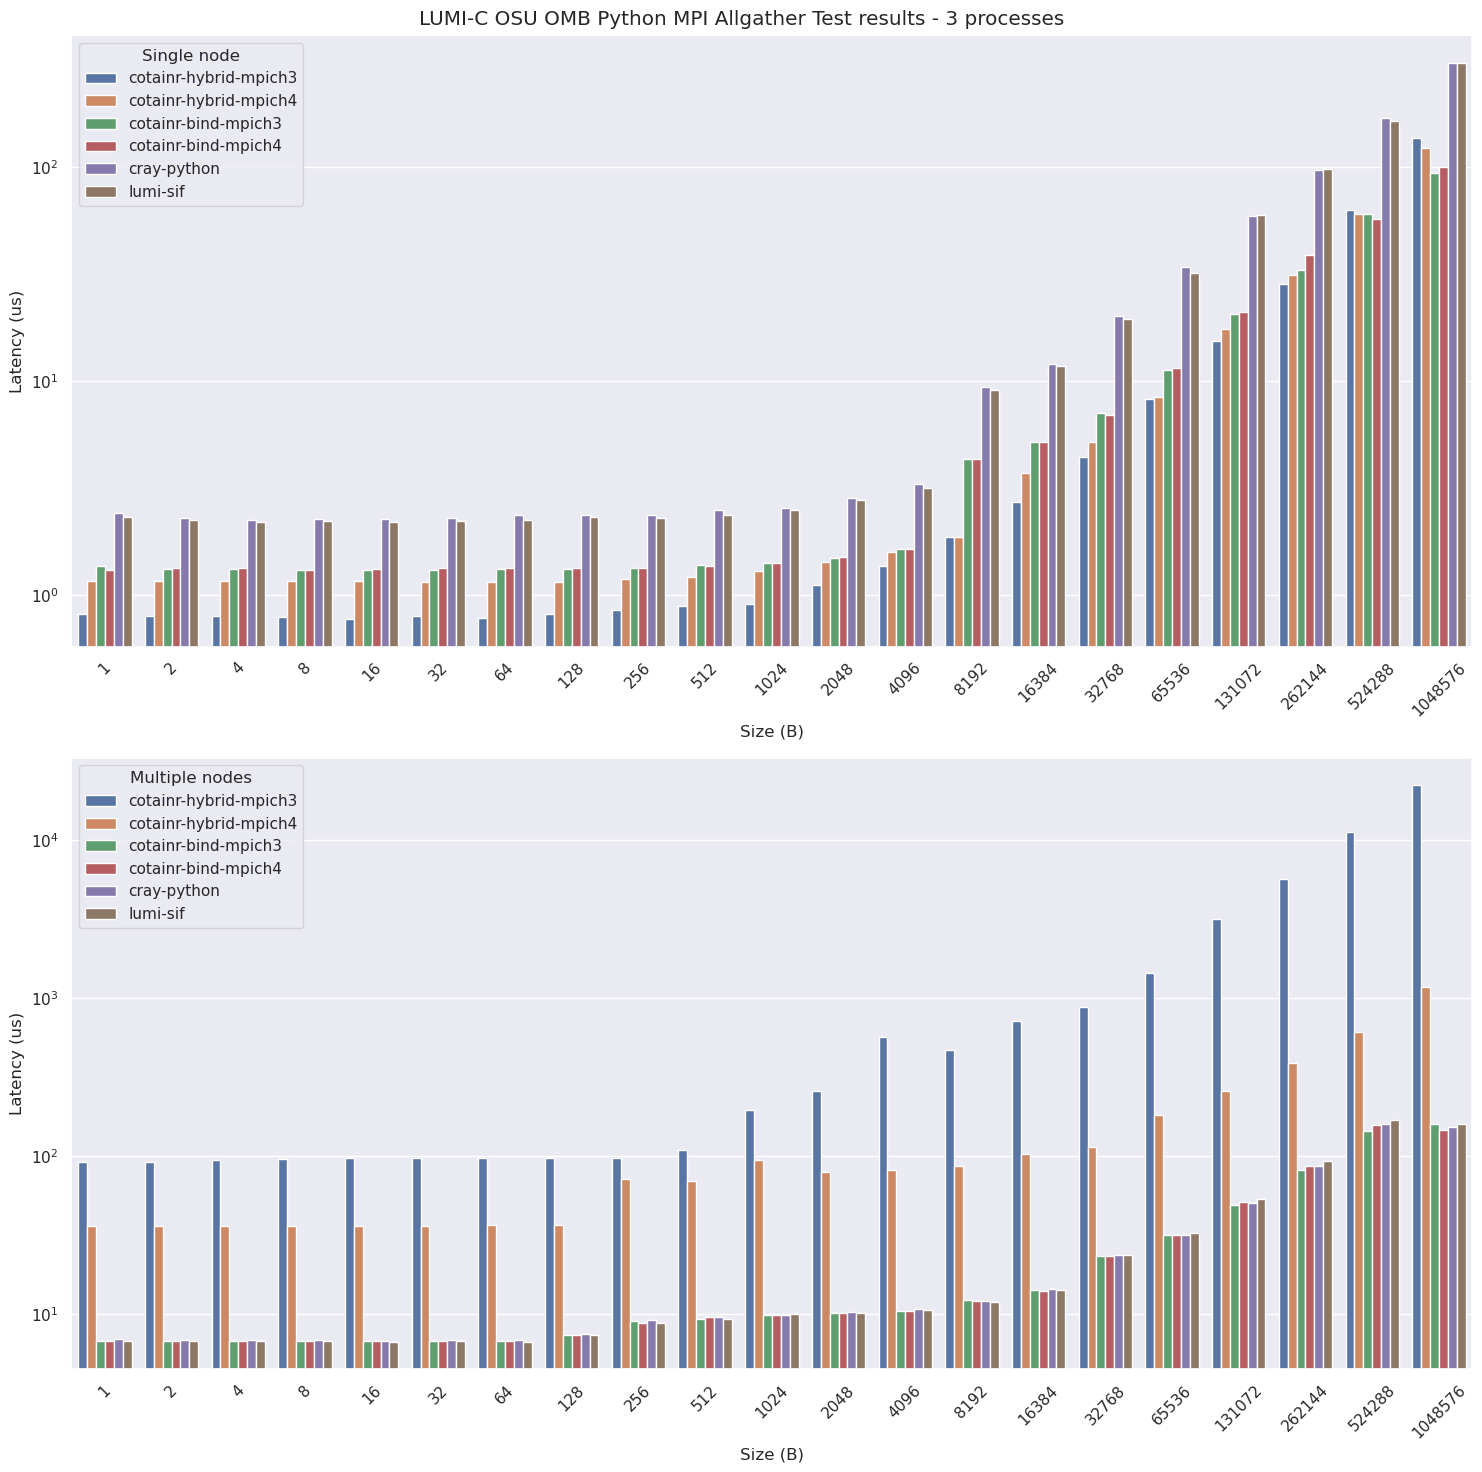

In [6]:
fig_allgather = barplot_osu_results(
    df=osu_result_dfs["allgather"],
    metric=tests["allgather"]["metric"],
    processes=tests["allgather"]["processes"],
    test_methods=test_methods
)

## Bandwidth test results

In [7]:
show_osu_pivot_table(
    df=osu_result_dfs["bw"], metric=tests["bw"]["metric"], test_methods=test_methods
)

Bandwidth (MB/s)                                         \
Test method cotainr-hybrid-mpich3         cotainr-hybrid-mpich4            
Nodes                      single   multi                single    multi   
Size (B)                                                                   
1                            2.51    0.22                  1.72     0.15   
2                            4.75    0.42                  3.53     0.30   
4                            9.53    0.84                  7.01     0.60   
8                           19.21    1.64                 14.12     1.20   
16                          39.43    3.25                 28.24     2.38   
32                          76.33    6.50                 57.31     4.62   
64                         153.41   11.90                112.31     8.81   
128                        318.74   21.30                220.43    16.93   
256                        592.36   39.29                438.10    19.70   
512                       1111.88   59.31                834.96    38.40   
1024                      2289.89   77.00               1676.96    52.41   
2048                      3887.12   96.82               3005.73   110.93   
4096                      6329.22  106.48               5790.77   217.19   
8192                     10507.06  114.26               9892.62   416.61   
16384                    16108.09  116.25              11208.24   731.37   
32768                    20177.61  117.54              15246.26  1245.51   
65536                    13359.12  117.96              19179.62  1809.23   
131072                   14899.79  117.86              22464.66  2615.63   
262144                   16668.34  118.26              22288.26  3089.58   
524288                   17533.16  118.49              24748.13  3629.43   
1048576                  18030.82  118.56              25539.96  4063.92   
2097152                  18174.78  118.61              26041.06  4198.40   
4194304                  18368.83  118.62              25875.76  4163.47   

                                                                         \
Test method cotainr-bind-mpich3           cotainr-bind-mpich4             
Nodes                    single     multi              single     multi   
Size (B)                                                                  
1                          2.45      1.24                2.38      1.14   
2                          4.99      2.62                4.78      2.40   
4                         10.10      5.22                9.80      4.86   
8                         20.22     10.37               19.59      9.98   
16                        40.43     20.90               38.90     20.65   
32                        79.97     41.84               75.18     41.06   
64                       160.27     84.05              153.61     82.56   
128                      316.05    168.58              303.69    166.10   
256                      616.01    312.70              587.18    312.14   
512                     1193.33    654.38             1106.97    655.60   
1024                    2310.71   1306.92             2188.06   1308.85   
2048                    4158.57   2618.29             4030.02   2602.45   
4096                    7114.03   5154.44             6978.31   5100.31   
8192                    4495.62  10225.77             4607.74  10221.59   
16384                   6920.27  19129.91             7211.01  19115.46   
32768                   9608.92  20645.54            10133.27  20567.37   
65536                  11731.41  22029.76            12472.64  22023.93   
131072                 13174.30  23043.79            14425.32  23053.28   
262144                 13841.77  23533.79            14851.48  23539.40   
524288                 14728.08  23789.01            15531.32  23782.28   
1048576                15984.33  23892.97            16311.23  23885.66   
2097152                16609.08  23950.71            16699.83  23944.84   
4194304       

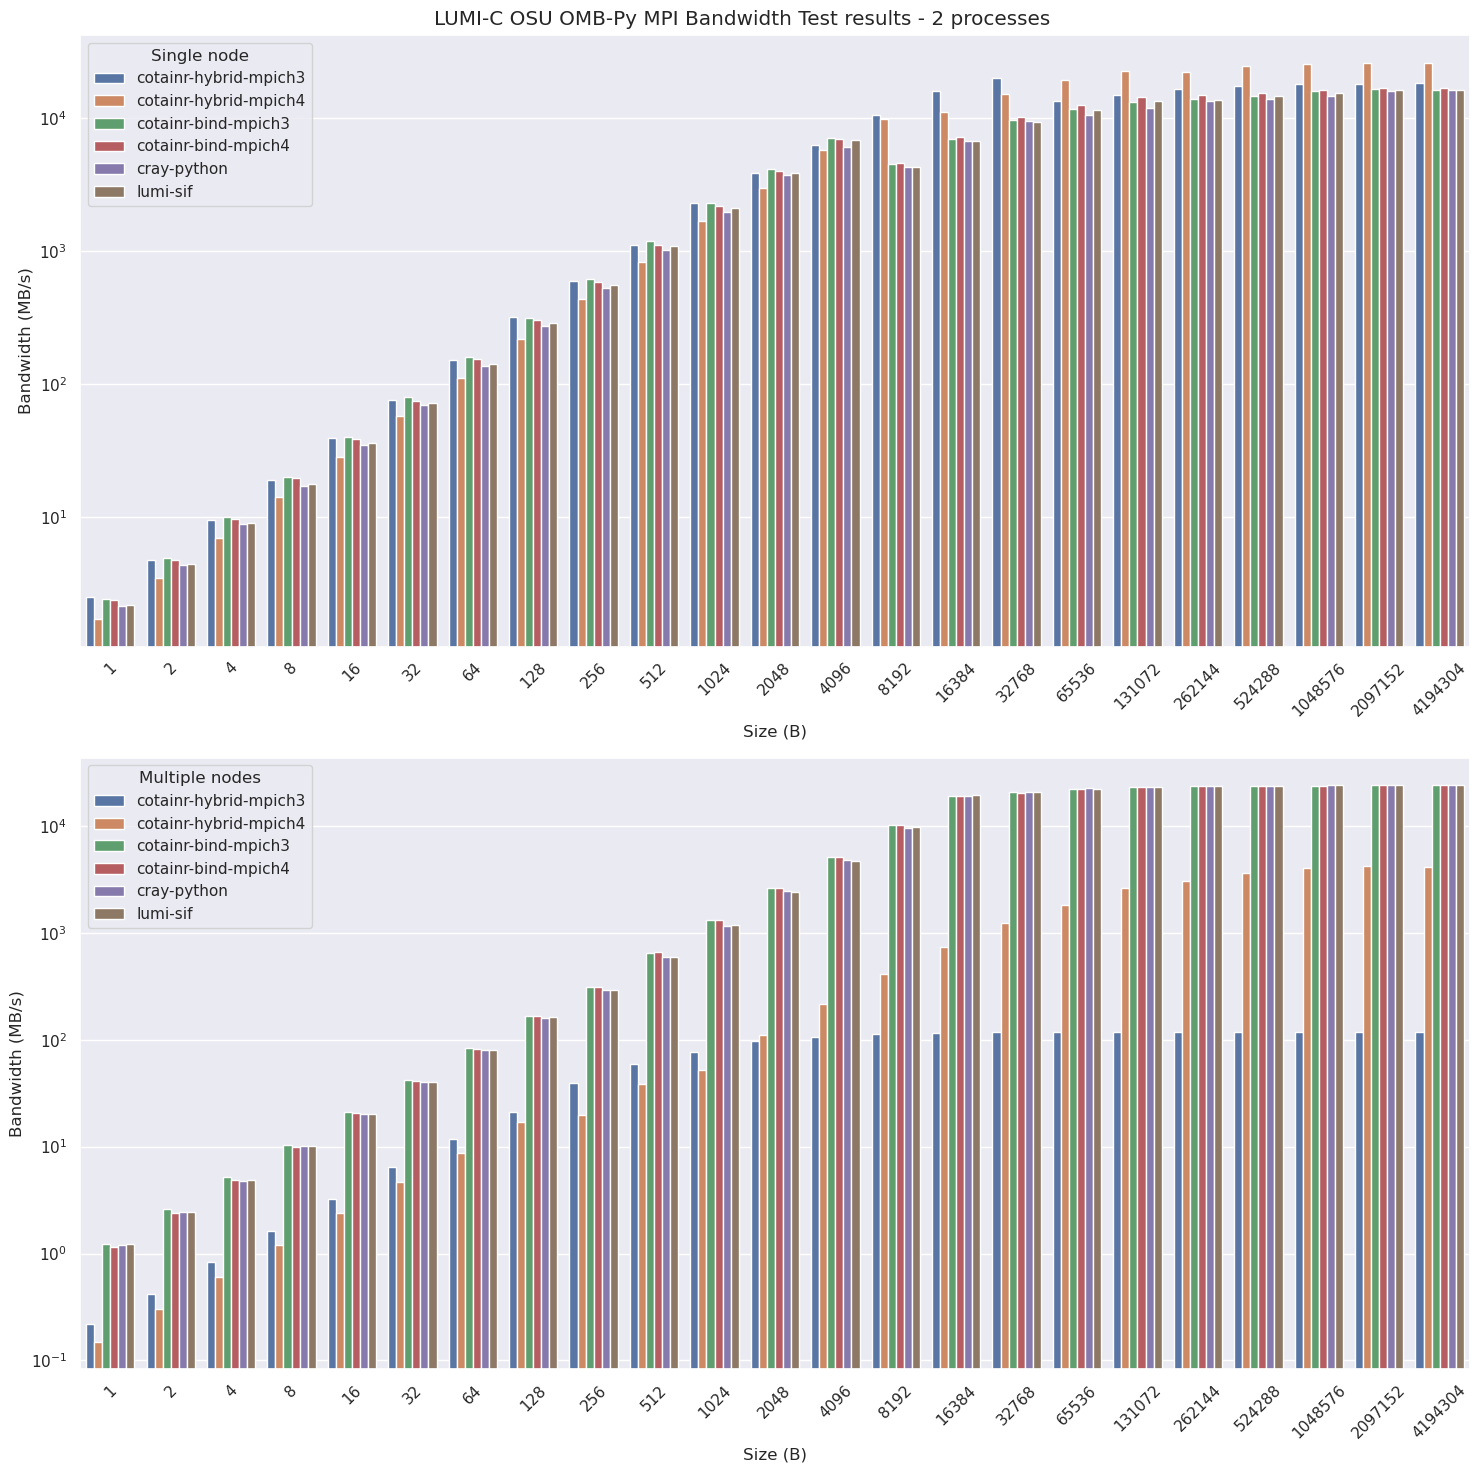

In [8]:
fig_bandwidth = barplot_osu_results(
    df=osu_result_dfs["bw"],
    metric=tests["bw"]["metric"],
    processes=tests["bw"]["processes"],
    test_methods=test_methods,
)

## Latency test results

In [9]:
show_osu_pivot_table(
    df=osu_result_dfs["latency"],
    metric=tests["latency"]["metric"],
    test_methods=test_methods,
)

Latency (us)                                           \
Test method cotainr-hybrid-mpich3           cotainr-hybrid-mpich4            
Nodes                      single     multi                single    multi   
Size (B)                                                                     
0                            0.46     24.52                  0.62    21.20   
1                            0.46     24.56                  0.62    21.20   
2                            0.45     24.52                  0.62    21.16   
4                            0.48     24.53                  0.62    21.22   
8                            0.44     24.54                  0.62    21.28   
16                           0.43     24.51                  0.62    21.21   
32                           0.47     24.52                  0.62    21.25   
64                           0.48     24.67                  0.62    21.24   
128                          0.49     26.78                  0.62    21.25   
256                          0.55     49.00                  0.64    27.93   
512                          0.54     55.00                  0.69    30.97   
1024                         0.58     80.10                  0.74    36.32   
2048                         0.70    113.39                  0.82    32.25   
4096                         0.91    164.36                  0.93    32.98   
8192                         1.29    205.38                  1.10    33.92   
16384                        1.97    249.47                  2.39    38.75   
32768                        3.15    429.62                  3.00    44.90   
65536                        3.63    767.06                  4.31    64.24   
131072                       5.38   1680.39                  8.33    86.88   
262144                      11.82   2514.61                 15.66   125.63   
524288                      23.39   4776.45                 27.00   199.75   
1048576                     50.85   9203.02                 49.03   337.87   
2097152                    105.42  18048.59                 92.87   614.06   
4194304                    217.77  35680.18                180.03  1165.31   

                                                                     \
Test method cotainr-bind-mpich3         cotainr-bind-mpich4           
Nodes                    single   multi              single   multi   
Size (B)                                                              
0                          0.94    2.71                0.90    2.70   
1                          0.93    2.75                0.91    2.71   
2                          0.93    2.72                0.91    2.73   
4                          0.91    2.70                0.90    2.72   
8                          0.91    2.71                0.90    2.73   
16                         0.91    2.71                0.90    2.73   
32                         0.93    2.71                0.91    2.72   
64                         0.94    2.70                0.91    2.73   
128                        0.95    3.26                0.92    3.26   
256                        0.98    3.52                0.94    3.59   
512                        1.00    3.49                1.04    3.55   
1024                       1.04    3.59                1.03    3.56   
2048                       1.10    3.67                1.09    3.70   
4096                       1.20    3.89                1.21    3.92   
8192                       2.82    4.23                2.68    4.24   
16384                      3.43    4.82                3.26    4.86   
32768                      4.68    8.04                4.62    8.13   
65536                      6.66    9.51                6.79    9.49   
131072                    11.18   12.33               11.59   12.30   
262144                    20.79   17.64               20.36   17.71   
524288                    39.58   28.55               38.91   28.53   
1048576                   71.18   50.26               71.00  

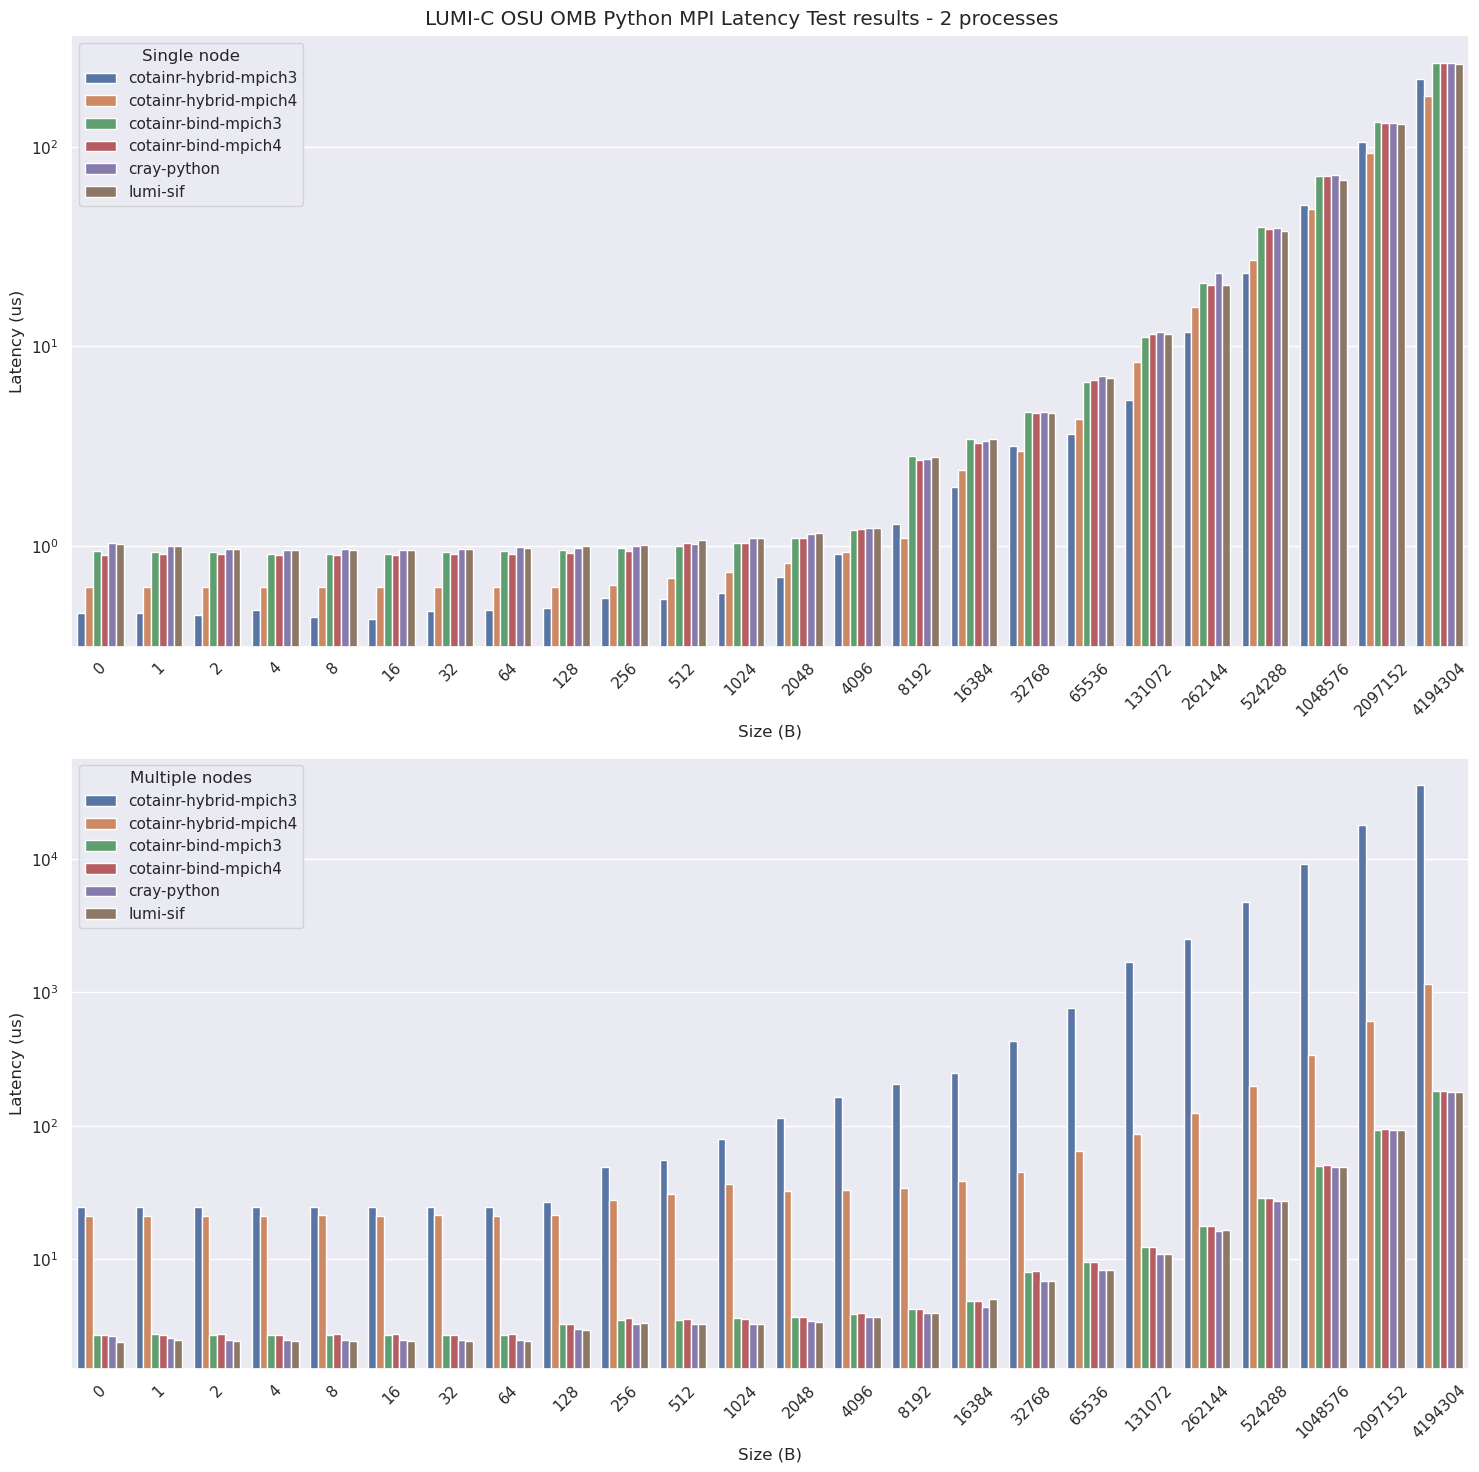

In [10]:
fig_latency = barplot_osu_results(
    df=osu_result_dfs["latency"],
    metric=tests["latency"]["metric"],
    processes=tests["latency"]["processes"],
    test_methods=test_methods,
)